In [ ]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
import urllib
import zipfile
import os
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score, classification_report

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
url = "http://nlp.stanford.edu/data/glove.6B.zip"
extract_dir = os.path.join(os.path.curdir, "glove")

if not os.path.exists(os.path.join(os.path.curdir, "glove", "glove.6B.300d.txt")):
    zip_path, _ = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(extract_dir)

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 128 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
data1 = pd.read_csv(os.path.join(os.path.curdir, "data", "train_all_tasks.csv")).fillna(' ')

In [ ]:
df = data1[data1.label_sexist == 'sexist']

In [ ]:
ndf = data1[data1.label_sexist == 'not sexist']

In [ ]:
add_df = ndf.sample(2000)

In [ ]:
frames = [add_df,df]
data = pd.concat(frames)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label_sexist'],
                                                    stratify=data['label_sexist'], 
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (4048,)
Test shape :  (1350,)


In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = os.path.join(os.path.curdir, "glove", "glove.6B.300d.txt")
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf-8"))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

E:\Softwares\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\dhana\AppData\Local\Temp\ipykernel_27276\2882071794.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/40 	 loss=84.0574 	 val_loss=80.7928  	 val_acc=0.6296  	 time=6.23s
Epoch 2/40 	 loss=83.2605 	 val_loss=80.6249  	 val_acc=0.6296  	 time=2.96s
Epoch 3/40 	 loss=83.0586 	 val_loss=80.4551  	 val_acc=0.6296  	 time=2.94s
Epoch 4/40 	 loss=82.8348 	 val_loss=80.1334  	 val_acc=0.6296  	 time=2.94s
Epoch 5/40 	 loss=82.4516 	 val_loss=79.6554  	 val_acc=0.6296  	 time=2.94s
Epoch 6/40 	 loss=81.7849 	 val_loss=78.9305  	 val_acc=0.6296  	 time=2.93s
Epoch 7/40 	 loss=80.9457 	 val_loss=77.9595  	 val_acc=0.6296  	 time=2.95s
Epoch 8/40 	 loss=79.7801 	 val_loss=76.7472  	 val_acc=0.6311  	 time=2.96s
Epoch 9/40 	 loss=78.2705 	 val_loss=75.0002  	 val_acc=0.6430  	 time=2.96s
Epoch 10/40 	 loss=76.4148 	 val_loss=73.1119  	 val_acc=0.6570  	 time=2.96s
Epoch 11/40 	 loss=73.9840 	 val_loss=70.8491  	 val_acc=0.6874  	 time=2.97s
Epoch 12/40 	 loss=71.3571 	 val_loss=68.6056  	 val_acc=0.7274  	 time=2.98s
Epoch 13/40 	 loss=68.7130 	 val_loss=66.6505  	 val_acc=0.7356  	 time=2

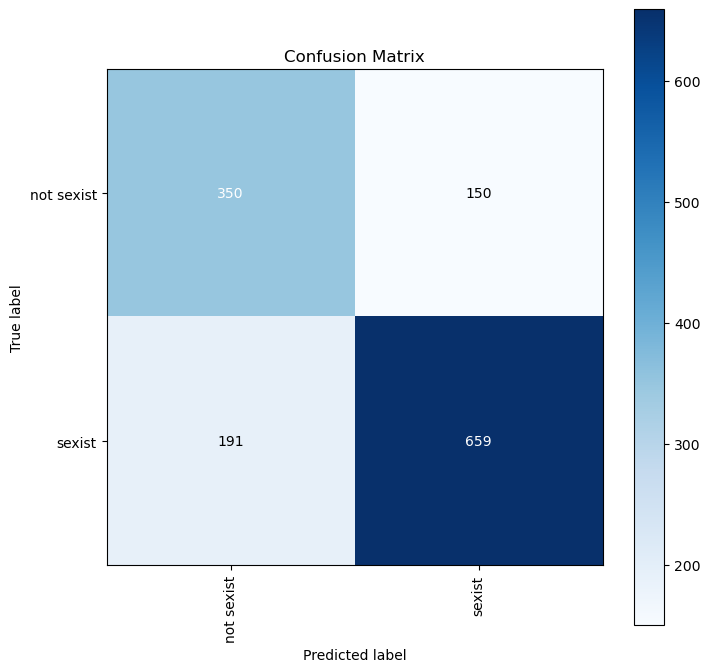

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_a_confusion_matrix"))

In [ ]:
print(classification_report(y_true, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_classification_report"), index= True)

              precision    recall  f1-score   support

  not sexist       0.65      0.70      0.67       500
      sexist       0.81      0.78      0.79       850

    accuracy                           0.75      1350
   macro avg       0.73      0.74      0.73      1350
weighted avg       0.75      0.75      0.75      1350



# **TASK B**

In [ ]:
df = data1[data1.label_sexist == 'sexist']

In [ ]:
ndf = data1[data1.label_sexist == 'not sexist']

In [ ]:
add_df = ndf.sample(800)

In [ ]:
frames = [add_df,df]
data = pd.concat(frames)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label_category'],
                                                    stratify=data['label_category'], 
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3148,)
Test shape :  (1050,)


In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\dhana\AppData\Local\Temp\ipykernel_27276\2882071794.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/40 	 loss=196.8560 	 val_loss=176.5472  	 val_acc=0.2771  	 time=2.52s
Epoch 2/40 	 loss=186.2951 	 val_loss=169.3286  	 val_acc=0.2952  	 time=2.35s
Epoch 3/40 	 loss=181.7986 	 val_loss=167.2409  	 val_acc=0.3790  	 time=2.34s
Epoch 4/40 	 loss=180.4180 	 val_loss=167.1589  	 val_acc=0.3790  	 time=2.35s
Epoch 5/40 	 loss=180.8972 	 val_loss=167.1243  	 val_acc=0.3790  	 time=2.34s
Epoch 6/40 	 loss=180.5390 	 val_loss=167.1011  	 val_acc=0.3790  	 time=2.35s
Epoch 7/40 	 loss=180.4904 	 val_loss=167.0608  	 val_acc=0.3790  	 time=2.34s
Epoch 8/40 	 loss=180.7407 	 val_loss=167.0281  	 val_acc=0.3790  	 time=2.35s
Epoch 9/40 	 loss=180.2488 	 val_loss=166.9951  	 val_acc=0.3790  	 time=2.34s
Epoch 10/40 	 loss=180.5064 	 val_loss=166.9463  	 val_acc=0.3790  	 time=2.35s
Epoch 11/40 	 loss=180.4267 	 val_loss=166.8898  	 val_acc=0.3790  	 time=2.34s
Epoch 12/40 	 loss=180.2151 	 val_loss=166.8456  	 val_acc=0.3790  	 time=2.33s
Epoch 13/40 	 loss=180.1843 	 val_loss=166.7888  

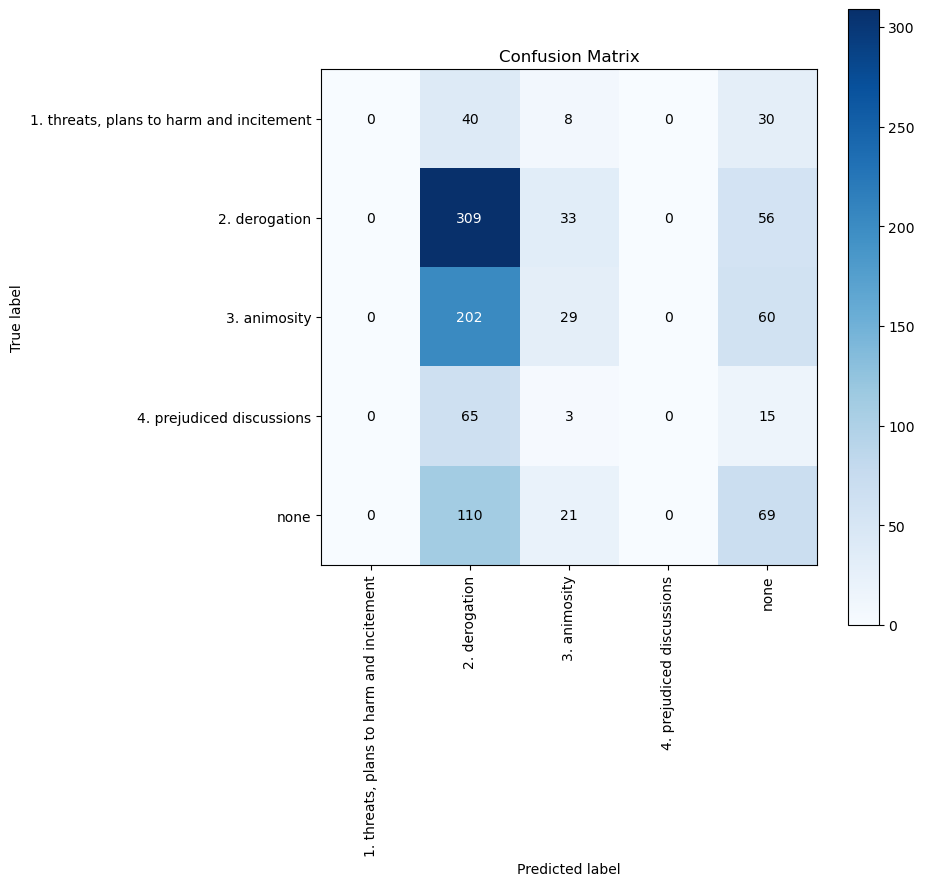

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_b_confusion_matrix"))

In [ ]:
print(classification_report(y_true, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_b_classification_report"), index= True)

                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        78
                           2. derogation       0.43      0.78      0.55       398
                            3. animosity       0.31      0.10      0.15       291
               4. prejudiced discussions       0.00      0.00      0.00        83
                                    none       0.30      0.34      0.32       200

                                accuracy                           0.39      1050
                               macro avg       0.21      0.24      0.20      1050
                            weighted avg       0.30      0.39      0.31      1050



E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla

# **TASK C**

In [ ]:
df = data1[data1.label_sexist == 'sexist']

In [ ]:
ndf = data1[data1.label_sexist == 'not sexist']

In [ ]:
add_df = ndf.sample(800)

In [ ]:
frames = [add_df,df]
data = pd.concat(frames)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label_vector'],
                                                    stratify=data['label_vector'], 
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3148,)
Test shape :  (1050,)


In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\dhana\AppData\Local\Temp\ipykernel_27276\2882071794.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/40 	 loss=306.7347 	 val_loss=278.5038  	 val_acc=0.1905  	 time=2.40s
Epoch 2/40 	 loss=294.0650 	 val_loss=265.2104  	 val_acc=0.1905  	 time=2.32s
Epoch 3/40 	 loss=281.6511 	 val_loss=256.5138  	 val_acc=0.1905  	 time=2.32s
Epoch 4/40 	 loss=275.5758 	 val_loss=253.4541  	 val_acc=0.1905  	 time=2.32s
Epoch 5/40 	 loss=273.6371 	 val_loss=252.3614  	 val_acc=0.1905  	 time=2.34s
Epoch 6/40 	 loss=272.9732 	 val_loss=251.8675  	 val_acc=0.1905  	 time=2.34s
Epoch 7/40 	 loss=272.7427 	 val_loss=251.6522  	 val_acc=0.1905  	 time=2.33s
Epoch 8/40 	 loss=272.4822 	 val_loss=251.4068  	 val_acc=0.1905  	 time=2.33s
Epoch 9/40 	 loss=272.1332 	 val_loss=251.2618  	 val_acc=0.1905  	 time=2.33s
Epoch 10/40 	 loss=271.4911 	 val_loss=251.0826  	 val_acc=0.1914  	 time=2.34s
Epoch 11/40 	 loss=272.7963 	 val_loss=250.8920  	 val_acc=0.1914  	 time=2.33s
Epoch 12/40 	 loss=270.9238 	 val_loss=250.6864  	 val_acc=0.2200  	 time=2.34s
Epoch 13/40 	 loss=271.4041 	 val_loss=250.4593  

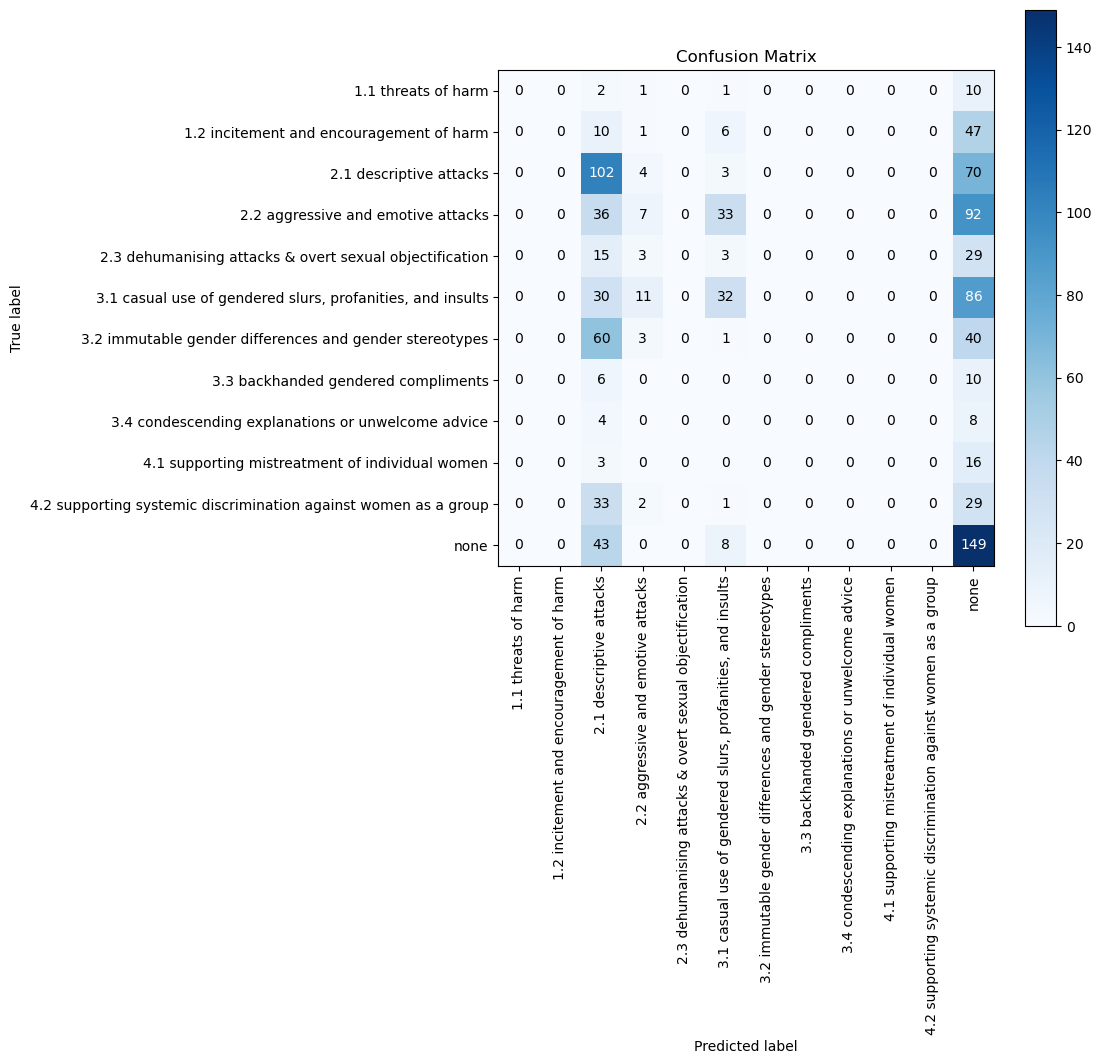

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_c_confusion_matrix"))

In [ ]:
print(classification_report(y_true, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_c_classification_report"), index= True)

                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.00      0.00      0.00        14
                       1.2 incitement and encouragement of harm       0.00      0.00      0.00        64
                                        2.1 descriptive attacks       0.30      0.57      0.39       179
                             2.2 aggressive and emotive attacks       0.22      0.04      0.07       168
        2.3 dehumanising attacks & overt sexual objectification       0.00      0.00      0.00        50
     3.1 casual use of gendered slurs, profanities, and insults       0.36      0.20      0.26       159
        3.2 immutable gender differences and gender stereotypes       0.00      0.00      0.00       104
                            3.3 backhanded gendered compliments       0.00      0.00      0.00        16
             3.4 condescending explanations or unwelco

E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla

In [ ]:
import numpy as np

# Load the GloVe embeddings into memory
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Build the vocabulary and prepare the text samples
tokenizer = Tokenizer()
texts = [ ... ] # List of text samples
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Create the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector